# 使用预训练词嵌入

下载imdb数据的原始文本 http://mng.bz/0tIo
下载glove词嵌入 https://nlp.stanford.edu/projects/glove

将训练评论转换成为字符串列表
每个字符串对应一条评论

In [1]:
import os

imdb_dir = '/home/wufisher/dataset_m/lan_glo_imdb/aclImdb'
train_dir= os.path.join(imdb_dir,'train')

labels=[]
texts=[]

for label_type in ['neg','pos']:
    dir_name = os.path.join(train_dir,label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:]=='.txt':
            f = open(os.path.join(dir_name,fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)


进行分词

In [2]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import numpy as np


maxlen=100
#100个单词后截断
training_samples=200
#两百个样本训练
validation_samples=10000
#10000个样本训练
max_words=10000
#只考虑训练集中10000个最常见的单词


tokenizer =Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.'% len(word_index))

data= pad_sequences(sequences,maxlen=maxlen)

labels = np.asarray(labels)
print('Shape  of data tensor:',data.shape)
print('Shape of label tensor:',labels.shape)


# 由于数据集中是排好顺序的，所以这里需要打乱以下
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data=data[indices]
labels = labels[indices]

x_train=data[:training_samples]
y_train=labels[:training_samples]

x_val=data[training_samples:training_samples+validation_samples]
y_val=labels[training_samples:training_samples+validation_samples]

Found 88582 unique tokens.
Shape  of data tensor: (25000, 100)
Shape of label tensor: (25000,)


预处理glove文件 .txt映射为向量索引

In [3]:
glove_dir = '/home/wufisher/dataset_m/lan_glo_imdb/glove.6B'

embeddings_index={}

f = open(os.path.join(glove_dir,'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:],dtype='float32')
    embeddings_index[word]=coefs
f.close()

准备能够加载到embedding层中的嵌入矩阵，必须形状为（max_word,embedding_dim）
索引为i的单词，对应embedding_dim维向，注意索引0不应该代表任何单词和占位
embedding层可以输入整数索引矩阵所以这里没问题

In [4]:
embedding_dim =100
embedding_martix = np.zeros((max_words,embedding_dim))
for word , i in word_index.items():
    if i<max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_martix[i]=embedding_vector



In [5]:
from keras.models import Sequential
from keras.layers import Embedding,Flatten,Dense

model= Sequential()
model.add(Embedding(max_words,embedding_dim,input_length=maxlen))
model.add(Flatten())
model.add(Dense(32,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1000000   
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 32)                320032    
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


2021-12-15 20:40:26.885217: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-15 20:40:27.391160: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9140 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:65:00.0, compute capability: 7.5


嵌入矩阵

In [6]:
model.layers[0].set_weights([embedding_martix])
#冻结
model.layers[0].trainable=False

训练

In [7]:
print(x_val)

[[   0    0    0 ...   15   32 1302]
 [9613 2695 3546 ...    7  705  155]
 [ 625    2 4229 ...  430   71   12]
 ...
 [1129 2685   44 ...   97   27 7595]
 [   7    8   29 ...    7  961  467]
 [ 200   27 7216 ...  302 3603 1553]]


In [8]:
model.compile(optimizer='rmsprop',
loss='binary_crossentropy',
metrics=['acc'])
history=model.fit(x_train,y_train,epochs=10,batch_size=32,validation_data=(x_val,y_val))
model.save_weights('/home/wufisher/dataset_m/h5inside/lan_glove_model.h5')

Epoch 1/10
7/7 [==============================] - 2s 152ms/step - loss: 1.2991 - acc: 0.4850 - val_loss: 0.9926 - val_acc: 0.5004
Epoch 2/10
7/7 [==============================] - 1s 139ms/step - loss: 0.6411 - acc: 0.6150 - val_loss: 0.7693 - val_acc: 0.5056
Epoch 3/10
7/7 [==============================] - 1s 144ms/step - loss: 0.4366 - acc: 0.7900 - val_loss: 0.6843 - val_acc: 0.5697
Epoch 4/10
7/7 [==============================] - 1s 136ms/step - loss: 0.2706 - acc: 0.9350 - val_loss: 0.7169 - val_acc: 0.5553
Epoch 5/10
7/7 [==============================] - 1s 149ms/step - loss: 0.6214 - acc: 0.7000 - val_loss: 0.6912 - val_acc: 0.5768
Epoch 6/10
7/7 [==============================] - 1s 160ms/step - loss: 0.1050 - acc: 0.9950 - val_loss: 0.7002 - val_acc: 0.5756
Epoch 7/10
7/7 [==============================] - 1s 152ms/step - loss: 0.0883 - acc: 1.0000 - val_loss: 0.9106 - val_acc: 0.5244
Epoch 8/10
7/7 [==============================] - 1s 152ms/step - loss: 0.0721 - acc: 1.00

In [9]:
print(history.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


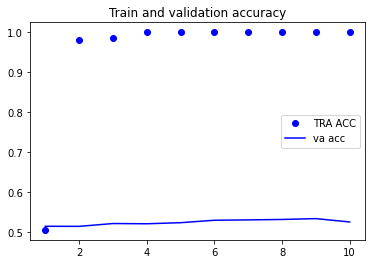

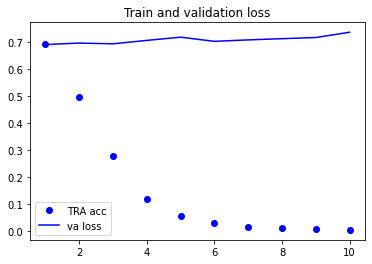

In [14]:
import matplotlib.pyplot as plt

acc= history.history['acc']
val_acc = history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs = range(1,len(acc)+1)

plt.plot(epochs,acc,'bo',label='TRA ACC')
plt.plot(epochs,val_acc,'b',label='va acc')
plt.title('Train and validation accuracy')
plt.legend()
plt.savefig('glove_emb_lan_acc.png')
plt.figure()

plt.plot(epochs,loss,'bo',label='TRA acc')
plt.plot(epochs,val_loss,'b',label='va loss')
plt.title('Train and validation loss')
plt.legend()

plt.savefig('glove_emb_lan_loss.png')
plt.show()

在来看一下不用词嵌入

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          1000000   
                                                                 
 flatten_2 (Flatten)         (None, 10000)             0         
                                                                 
 dense_4 (Dense)             (None, 32)                320032    
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
7/7 [==============================] - 1s 170ms/step - loss: 0.6932 - acc: 0.5150 - val_loss: 0.6923 - val_acc: 0.5145
Epoch 2/10
7/7 [==============================

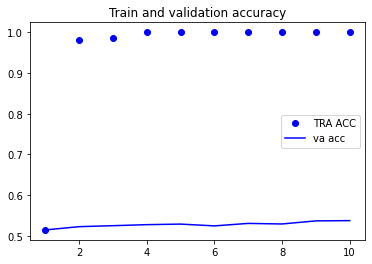

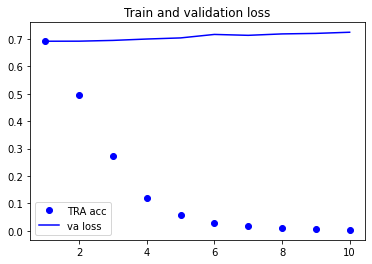

In [15]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(optimizer='rmsprop',
loss='binary_crossentropy',
metrics=['acc'])
history = model.fit(x_train, y_train,
epochs=10,
batch_size=32,
validation_data=(x_val, y_val))

acc= history.history['acc']
val_acc = history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs = range(1,len(acc)+1)

plt.plot(epochs,acc,'bo',label='TRA ACC')
plt.plot(epochs,val_acc,'b',label='va acc')
plt.title('Train and validation accuracy')
plt.legend()

plt.savefig('without_glove_emb_lan_acc.png')
plt.figure()

plt.plot(epochs,loss,'bo',label='TRA acc')
plt.plot(epochs,val_loss,'b',label='va loss')
plt.title('Train and validation loss')
plt.legend()

plt.savefig('without_glove_emb_lan_loss.png')
plt.show()

显然预训练词的加入更好
现在我们来测试一下第一个模型

In [13]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)
sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

model.load_weights('/home/wufisher/dataset_m/h5inside/lan_glove_model.h5')
model.evaluate(x_test,y_test)

782/782 [==============================] - 3s 3ms/step - loss: 0.7589 - acc: 0.5725


[0.7588797807693481, 0.5724800229072571]

精度达到惊人的57%效果还是非常perfect